In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [600]:
import yfinance as yf
stock_symbol = 'TWTR'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-04-14,48.369999,48.500000,44.720001,45.080002,45.080002,257199200
501,2022-04-18,46.240002,48.730000,44.360001,48.450001,48.450001,153119600
502,2022-04-19,47.299999,48.500000,45.000000,46.160000,46.160000,125776000
503,2022-04-20,46.340000,47.110001,45.029999,46.720001,46.720001,63360000
504,2022-04-21,45.509998,47.939999,45.500000,47.080002,47.080002,70167100


#### Visualizing the Real Stock Trend

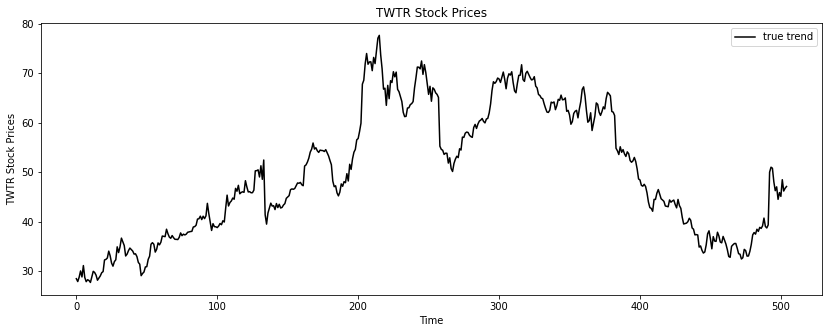

In [601]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [602]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [603]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,27.000000,28.500000,26.450001,28.440001,28558000
1,28.430000,28.840000,27.730000,27.860001,19019600
2,27.990000,28.840000,27.459999,28.740000,15923400
3,29.129999,30.389999,29.129999,30.000000,22490600
4,30.400000,30.450001,28.570000,28.790001,23364000


In [604]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.        , 0.00152876, 0.        , 0.01521522, 0.2348906 ])

In [605]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((385, 60, 5), (385,))

#### Preparaing testing data

In [606]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
           Open       High        Low      Close    Volume
 385  54.009998  54.480000  53.150002  53.540001  14832400
 386  53.560001  55.330002  53.410000  55.110001  14747000
 387  55.040001  55.080002  53.779999  53.990002  11571400
 388  53.680000  54.549999  53.099998  54.529999   9774200
 389  54.580002  54.840000  53.180000  53.680000  11284700)

In [607]:
df = scaler.transform(df)
df[0]

array([0.5258956 , 0.49799349, 0.53830644, 0.51771776, 0.10539599])

In [608]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [609]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [610]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### RNN - Recurrent Neural Network

In [611]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

In [612]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [613]:
model = Sequential()

# Input layer
model.add(SimpleRNN(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))

# 2nd layer (Hidden)
model.add(SimpleRNN(units=60,activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_48 (SimpleRNN)   (None, 60, 40)            1840      
                                                                 
 dropout_48 (Dropout)        (None, 60, 40)            0         
                                                                 
 simple_rnn_49 (SimpleRNN)   (None, 60)                6060      
                                                                 
 dropout_49 (Dropout)        (None, 60)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 61        
                                                                 
Total params: 7,961
Trainable params: 7,961
Non-trainable params: 0
_________________________________________________________________


In [614]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [615]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=64)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [616]:
def first_forecast():
    history = model.fit(x_train,y_train,epochs=300,batch_size=64)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return history,y_pred

In [617]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
7/7 [==============================] - 2s 18ms/step - loss: 0.5887 - accuracy: 0.0000e+00
Epoch 2/300
7/7 [==============================] - 0s 18ms/step - loss: 0.1742 - accuracy: 0.0000e+00
Epoch 3/300
7/7 [==============================] - 0s 20ms/step - loss: 0.0416 - accuracy: 0.0026
Epoch 4/300
7/7 [==============================] - 0s 24ms/step - loss: 0.0401 - accuracy: 0.0026
Epoch 5/300
7/7 [==============================] - 0s 17ms/step - loss: 0.0268 - accuracy: 0.0026
Epoch 6/300
7/7 [==============================] - 0s 17ms/step - loss: 0.0256 - accuracy: 0.0026
Epoch 7/300
7/7 [==============================] - 0s 17ms/step - loss: 0.0230 - accuracy: 0.0026
Epoch 8/300
7/7 [==============================] - 0s 19ms/step - loss: 0.0196 - accuracy: 0.0026
Epoch 9/300
7/7 [==============================] - 0s 17ms/step - loss: 0.0216 - accuracy: 0.0026
Epoch 10/300
7/7 [==============================] - 0s 17ms/step - loss: 0.0181 - accuracy: 0.002

#### Calculating the Accuracy using MAPE and RMSE

In [618]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[91.48808586954767]

In [619]:
# RMSE - Root Mean Squared Error 
def calculate_rmse(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict)/real)))
    return percentage * 100
mean_rmse = []
for i in range(simulation):
    mean_rmse.append(calculate_rmse(y_test, result_forecast[i]))

mean_rmse,np.mean(mean_rmse)

([88.52530661484738], 88.52530661484738)

#### Visualization

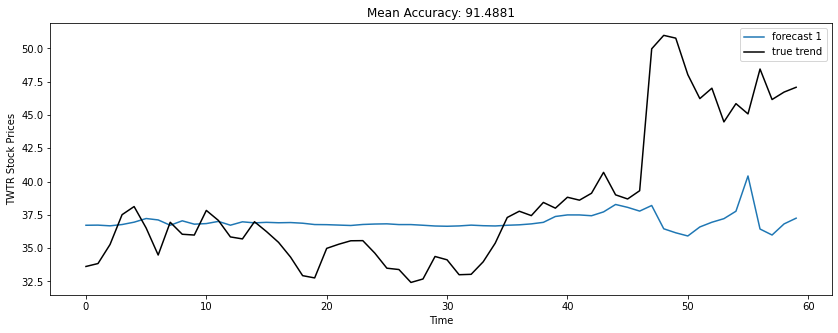

In [620]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [621]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

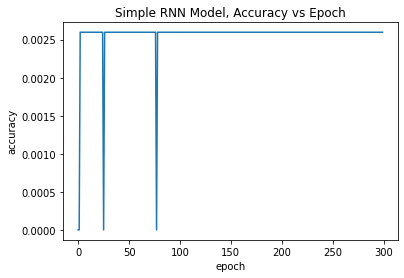

In [622]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Simple RNN Model, Accuracy vs Epoch')
plt.show()

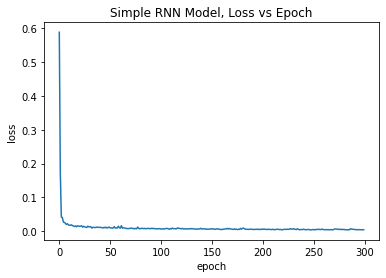

In [623]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Simple RNN Model, Loss vs Epoch')
plt.show()

#### Predicting future trend

In [624]:
present_test_set = data_test
present_test_set = present_test_set.drop(['Date','Adj Close'],axis=1)

#scale the data
present_input = scaler.transform(present_test_set)

# preparing the arrays according to the test_size
present_test = []
present_test.append(present_input)

for i in range(1,test_size):
    a = [0,0,0,0,0]
    ar = []
    for j in range(0,test_size):
        ar.append(a)
    present_test.append(ar)

present_test = np.array(present_test)

y = model.predict(present_test)
predicted_value = y.reshape(-1,1)
predicted_value = scaler_close.inverse_transform(predicted_value)
print("Next Day's Predicted Closing Index = %f"%predicted_value[0])

Next Day's Predicted Closing Index = 37.670197


### Final Analysis

>**Dataset:**
>* GOOG
>* 2y  
>
>**Training Timestamp:**
>* 60 days
>  
>**Model:**
>* 3 layers - (1 Input + 1 Hidden + 1 Output)
>* RNN layers - activation = relu
>* RNN layers - units = 40,60
>* RNN layers - dropout = 0.2,0.2
>* Dense layer - units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 300
>* batch_size = 64
>
>**Mean Accuracy:**
>* MAPE - 91.11%
>* RMSE - 86.01%

**Predicted Closing Index for 29th March: 2713.892578**